# Air Passengers Prediction - Machine Learning

In [21]:
import numpy as np
import pandas as pd

import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")


In [22]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)

In [23]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [24]:
#import dataset
df = pd.read_csv('AirPassengers.csv')
print(df)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


In [25]:
df.columns = ["Month", "Passengers"]
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [26]:
df["Month"] = pd.to_datetime(df["Month"])
df.index = df["Month"]
df.drop("Month", axis=1, inplace=True)
data = df["Passengers"].values
data = data.astype("float32")
data = data.reshape(-1,1)

In [27]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [28]:
data.shape

(144, 1)

In [ ]:
#Train and test data --b. Divide the data into train and test set 

In [29]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [30]:
train, test, position = split_data(df, 0.33)
print("Train shape:", train.shape, " Test shape:", test.shape)

Train shape: (96, 1)  Test shape: (48, 1)


In [ ]:
#Encoding data

In [31]:
def encoding_scaling(train, test):
  scaler_train = MinMaxScaler(feature_range=(0,1))
  train = scaler_train.fit_transform(train)
  scaler_test = MinMaxScaler(feature_range=(0,1))
  test = scaler_test.fit_transform(test)
  return scaler_train, train, scaler_test, test

In [32]:
scaler_train, train, scaler_test, test  = encoding_scaling(train, test)

In [33]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X), np.array(Y)

In [34]:
X_train, y_train = create_features(train, 1)
X_test, y_test = create_features(test, 1)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (95, 1)  y_train shape: (95,) 
X_test shape: (47, 1)  y_test shape:  (47,)


In [35]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (95, 1, 1)  y_train shape: (95, 1) 
X_test shape: (47, 1, 1)  y_test shape:  (47, 1)


In [36]:
def RNN_create_and_fit_model(X_train,y_train, X_test, y_test, lookback=1, epochs=50, summary=True, fit=True):
  model = Sequential()
  model.add(SimpleRNN(units=50, activation="relu", input_shape=(X_train.shape[1], lookback)))
  model.add(Dropout(0.2))
  model.add(Dense(1))

  model.compile(loss="mean_squared_error", optimizer="adam")
  callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"), 
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]
  
  if summary:
    model.summary()
  
  if fit:
    history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=1, 
                      validation_data=(X_test, y_test), callbacks=callbacks, shuffle=False)
  
  return model, history

In [37]:
model, history = RNN_create_and_fit_model(X_train,y_train, X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
57/95 [=================>............] - ETA: 0s - loss: 0.0118  
Epoch 1: val_loss improved from inf to 0.04062, saving model to mymodel.h5
95/95 [==============================] - 1s 4ms/step - loss: 0.0145 - val_loss: 0.0406
Epoch 2/50
55/95 [================>............

In [38]:
def RNN_model_evaluate(model):
  loss = model.evaluate(X_test, y_test, batch_size=1)
  print("Test Loss: %.2f" % (100 * loss))
  plt.figure(figsize=(10,5))
  plt.plot(history.history["loss"], color="r", label="Training Loss")
  plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Loss", fontsize=16)
  plt.ylim([0, max(plt.ylim())])
  plt.title("Training and Validation Loss", fontsize=16);

47/47 [==============================] - 0s 934us/step - loss: 0.0211
Test Loss: 2.11


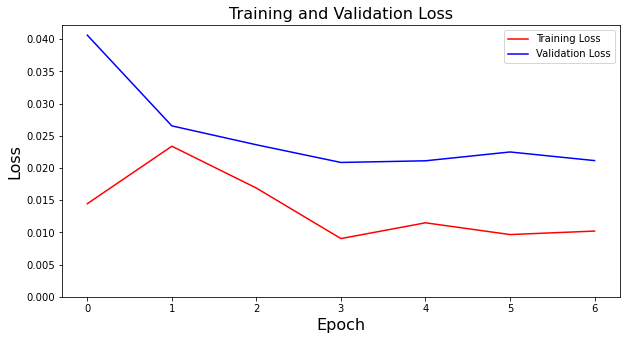

In [39]:
RNN_model_evaluate(model)

In [40]:
def show_prediction(model, dataframe, X_train, X_test, y_train, y_test, lookback=1, plot=True):
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  train_predict = scaler_train.inverse_transform(train_predict)
  test_predict = scaler_test.inverse_transform(test_predict) 
  y_train = scaler_train.inverse_transform(y_train)
  y_test = scaler_test.inverse_transform(y_test)
  RMSE_train = np.sqrt(mean_squared_error(y_train, train_predict))
  RMSE_test = np.sqrt(mean_squared_error(y_test, test_predict))
  print("############### Loss ###############")
  print("RMSE Train: ", RMSE_train, "\nRMSE Test: ", RMSE_test)

  train_prediction_df = dataframe[lookback:position]
  train_prediction_df["Predicted"] = train_predict
  print("############### Train Predictoion Head ###############")
  print(train_prediction_df.head())

  test_prediction_df = dataframe[position+lookback:]
  test_prediction_df["Predicted"] = test_predict
  print("############### Test Predictoion Head ###############")
  print(test_prediction_df.head())

  if plot:
    plt.figure(figsize=(14,5))
    plt.plot(dataframe, label="Real Number of Passengers")
    plt.plot(train_prediction_df["Predicted"], color="blue", label="Train Predicted Number of Passengers")
    plt.plot(test_prediction_df["Predicted"], color="red", label="Test Predicted Number of Passengers")
    plt.title("Number of Passengers Prediction")
    plt.xlabel("Time")
    plt.ylabel("Number of Passengers")
    plt.legend()
    plt.show()

2/2 [==============================] - 0s 997us/step
############### Loss ###############
RMSE Train:  24.03499654111205 
RMSE Test:  46.68095719368427
############### Train Predictoion Head ###############
            Passengers   Predicted
Month                             
1949-02-01         118  132.608337
1949-03-01         132  135.795181
1949-04-01         129  147.826981
1949-05-01         121  145.058884
1949-06-01         135  137.724045
############### Test Predictoion Head ###############
            Passengers   Predicted
Month                             
1957-02-01         301  333.699432
1957-03-01         356  326.388794
1957-04-01         348  370.438599
1957-05-01         355  363.057007
1957-06-01         422  369.515930


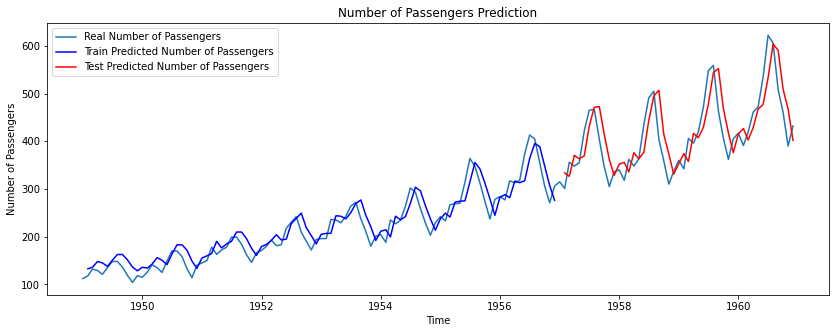

In [41]:
show_prediction(model, df, X_train, X_test, y_train, y_test)